# Зайцев Н. ПИ20-1В

<h1 align = 'center'> Классификация по настроению (анализ без нейронных сетей) отзывов на фильмы IMDb: Naive Bayes</h1>

Цель этой тетради - показать, как осуществляется классификация настроений с помощью метода `Naive Bayes`. А также познакомиться с методами предобработки текстовых данных библиотеки `fastai`.

Содержание тетради взято из [Урока 10 Курса машинного обучения fast.ai](https://course.fast.ai/lessonsml1/lesson10.html ). Линейная модель здесь довольно близка к современному уровню точности.  Только осенью 2017 года Джереми превзошел уровень точности, используя RNN.

## 0. Библиотека fastai

Начнем использовать [библиотеку fastai](https://docs.fast.ai ) (версия 1.0) в этой записной книжке.  Мы будем использовать его чаще, как только перейдем к нейронным сетям.

Библиотека fastai построена на базе `PyTorch` и кодирует множество передовых практик. Он используется в производстве на ряде компаний.  Вы можете прочитать больше об этом здесь:

- [Fast.ai's software could radically democratize AI](https://www.zdnet.com/article/fast-ais-new-software-could-radically-democratize-ai/) (ZDNet)

- [fastai v1 for PyTorch: Fast and accurate neural nets using modern best practices](https://www.fast.ai/2018/10/02/fastai-ai/) (fast.ai)

- [fastai docs](https://docs.fast.ai/)

### Установка

Через conda:

`conda install -c pytorch -c fastai fastai=1.0`

Или через pip:

`pip install fastai==1.0`

Больше [информации по установке здесь](https://github.com/fastai/fastai/blob/master/README.md).

## 1. Набор данных отзывов IMDB

<img src="../images/IMDb.png" alt="floating point" style="width: 30%"/>

[Большой набор данных для просмотра фильмов](http://ai.stanford.edu/~amaas/data/sentiment/) содержит коллекцию из 50 000 отзывов с IMDB, мы будем использовать версию, размещенную как часть [fast.ai наборы данных](https://course.fast.ai/datasets.html) в открытых наборах данных AWS.

Набор данных содержит четное количество положительных и отрицательных отзывов. Авторы рассматривали только сильно поляризованные отзывы. Отрицательный отзыв имеет оценку ≤ 4 из 10, а положительный отзыв имеет оценку ≥ 7 из 10. Нейтральные отзывы не включены в набор данных. Набор данных разделен на обучающий и тестовый наборы. Обучающий набор - это те же 25 000 помеченных отзывов.

Задача **классификации настроений** состоит в предсказании полярности (положительной или отрицательной) данного текста.

In [1]:
#!pip install fastai

In [2]:
#!pip install fastbook

### Импорт библиотек

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.text.all import *

In [5]:
import sklearn.feature_extraction.text as sklearn_text
import pickle

### Просмотр пробного набора данных IMDb

fast.ai имеет ряд наборов данных, размещенных через [AWS Open Datasets](https://course.fast.ai/datasets.html) для легкой загрузки. Мы можем увидеть их, проверив документы на наличие URL-адресов (помните `??` это полезная команда):

In [7]:
?? URLs

Всегда полезно начать работать с пробным образцом ваших данных, прежде чем использовать полный набор данных -- это позволяет ускорить вычисления по мере отладки и приведения вашего кода в рабочее состояние. Для IMDB уже доступен образец набора данных:

In [11]:
print(URLs.IMDB_SAMPLE)
path = untar_data('http://s3.amazonaws.com/fast-ai-sample/imdb_sample.tgz')
#path = untar_data(URLs.IMDB)
path.ls()

https://s3.amazonaws.com/fast-ai-sample/imdb_sample.tgz


(#1) [Path('/Users/nikitazaytsev/.fastai/data/imdb_sample/texts.csv')]

Считайте набор данных в фрейм данных pandas, который мы можем просмотреть, чтобы получить представление о том, как выглядят наши данные. Мы видим, что три столбца содержат метку проверки, текст проверки и флаг is_valid соответственно. is_valid -- это логический флаг, указывающий, является ли строка из набора проверки или нет.

In [12]:
df = pd.read_csv(path/'texts.csv')
print(df.shape)
df.head()

(1000, 3)


,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


Извлекем обзор фильмов из пробного набора данных IMDb.
Мы будем использовать [`TextDataLoaders`](https://docs.fast.ai/text.data.html#textdataloaders.from_folder) из библиотеки fastai:

In [16]:
device = torch.device('cpu')
movie_reviews = TextDataLoaders.from_df(df, path=path, text_col='text', label_col='label', valid_col='is_valid', device=device)
movie_reviews.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive
2,"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after 20 - odd years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside "" edgy "" projects . \n\n xxmaj none of this excuses him this present ,",negative


### Загрузчик данных

Хорошим первым шагом при решении любой проблемы с данными является изучение данных и представление о том, как они выглядят.  В данном случае мы рассматриваем рецензии на фильмы, которые были помечены как "положительные" или "отрицательные". Обзоры уже были `tokenized`, то есть разделены на `токены`, базовые единицы, такие как слова, префиксы, знаки препинания, заглавные буквы и другие особенности текста.

Давайте посмотрим на методы и атрибуты загрузчика данных `movie_reviews`:

In [17]:
dir(movie_reviews)[:5]

['_DataLoader__idxs', '__class__', '__delattr__', '__dict__', '__dir__']

In [18]:
movie_reviews._docs

{'__getitem__': 'Retrieve `DataLoader` at `i` (`0` is training, `1` is validation)',
 'train': 'Training `DataLoader`',
 'valid': 'Validation `DataLoader`',
 'train_ds': 'Training `Dataset`',
 'valid_ds': 'Validation `Dataset`',
 'to': 'Use `device`',
 'add_tfms': 'Add `tfms` to `loaders` for `event',
 'cuda': 'Use accelerator if available',
 'cpu': 'Use the cpu',
 'new_empty': 'Create a new empty version of `self` with the same transforms',
 'from_dblock': 'Create a dataloaders from a given `dblock`'}

In [19]:
movie_reviews.bs

64

In [20]:
np.array([len(i[0]) for i in movie_reviews.train]).sum()

768

Загрузчик `movie_reviews` отделяет данные на обучающие и валидационные, т.е. имеет атрибуты `.train` и `.valid` . Важно отметить, что в них отзывы находятся уже в векторизованном виде и разбиты по умолчанию на пакеты по 64 отзыва. 

In [21]:
print(f'Имеются {np.array([len(i[0]) for i in movie_reviews.train]).sum()} и {np.array([len(i[0]) for i in movie_reviews.valid]).sum()} отзывов в обучающем и валидационном наборах.')

Имеются 768 и 200 отзывов в обучающем и валидационном наборах.


Отзывы в `train` и `valid` состоят из списков векторов, которые получены из словаря токенов на основе их номера в словаре. В NLP **токен** является базовой единицей обработки (что это за токены, зависит от приложения и вашего выбора). Здесь токены в основном соответствуют словам или знакам препинания, а также нескольким специальным токенам, соответствующим неизвестным словам, заглавным буквам и т.д.

### Специальные токены:
Все эти токены, начинающиеся с "xx", являются специальными токенами fastai.  Вы можете увидеть список всех их и их значения [в документации по fastai](https://docs.fast.ai/text.transform.html):

### Рассмотрим содержимое обучающего набора данных

In [22]:
print(f'\f Имеется {len(df[df.is_valid == False])} отзывов в обучающем наборе\n')
df[df.is_valid == False].head()

 Имеется 800 отзывов в обучающем наборе



,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


Текст рецензии на фильм хранится в виде символьной строки, т.е.  `string`, которая содержит маркеры, разделенные пробелами. Вот текст первого обзора:

In [23]:
print(df[df.is_valid == False].text[0])
print(f'\n В первом отзыве содержится {len(df[df.is_valid == False].text[0])} символов')

Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!

 В первом отзыве содержится 405 символов


In [24]:
movie_reviews.tokenizer(df[df.is_valid == False].text[0])

(#108) ['xxbos','xxmaj','un','-','bleeping','-','believable','!','xxmaj','meg'...]

Этот текст можно разделить, чтобы получить список токенов.

In [25]:
print(movie_reviews.tokenizer(df[df.is_valid == False].text[0]))
print(f'\nОтзыв содержит {len(movie_reviews.tokenizer(df[df.is_valid == False].text[0]))} токенов')

['xxbos', 'xxmaj', 'un', '-', 'bleeping', '-', 'believable', '!', 'xxmaj', 'meg', 'xxmaj', 'ryan', 'does', "n't", 'even', 'look', 'her', 'usual', 'pert', 'lovable', 'self', 'in', 'this', ',', 'which', 'normally', 'makes', 'me', 'forgive', 'her', 'shallow', 'ticky', 'acting', 'schtick', '.', 'xxmaj', 'hard', 'to', 'believe', 'she', 'was', 'the', 'producer', 'on', 'this', 'dog', '.', 'xxmaj', 'plus', 'xxmaj', 'kevin', 'xxmaj', 'kline', ':', 'what', 'kind', 'of', 'suicide', 'trip', 'has', 'his', 'career', 'been', 'on', '?', 'xxmaj', 'whoosh', '…', 'xxmaj', 'banzai', 'xxrep', '3', '!', 'xxmaj', 'finally', 'this', 'was', 'directed', 'by', 'the', 'guy', 'who', 'did', 'xxmaj', 'big', 'xxmaj', 'chill', '?', 'xxmaj', 'must', 'be', 'a', 'replay', 'of', 'xxmaj', 'jonestown', '-', 'hollywood', 'style', '.', 'w', 'xxrep', '3', 'o', 'xxrep', '3', 'f', '!']

Отзыв содержит 108 токенов


Токены обзора можно пронумеровать, т.е. сопоставить с целыми числами.  Таким образом, обзор фильма также хранится в виде массива целых чисел в выборке `train`:

In [26]:
first_token_list = movie_reviews.tokenizer(df[df.is_valid == False].text[0])
print(np.array(movie_reviews.numericalize(first_token_list)))
print(f'\nМассив содержит {len(movie_reviews.numericalize(first_token_list))} номеров токенов в словаре')

[   2    8 4503   24    0   24  953   54    8 4504    8 1769   94   37
   78  198   62  852    0 2185  507   18   21   10   86 2038  192   90
 3817   62 1897    0  124    0   11    8  251   15  277   73   25    9
 1651   35   21 1140   11    8 1098    8 1353    8 2925   95   64  240
   14 1576 1485   65   41  790  107   35   69    8    0   87    8    0
    5  161   54    8  567   21   25  642   48    9  265   53   89    8
  218    8    0   69    8  234   43   13 4505   14    8 4506   24  392
  427   11 2628    5  161 1354    5  161 1288   54]

Массив содержит 108 номеров токенов в словаре


## 2. Словарь IMDb

Объект `movie_reviews` также содержит свойство `.vocab`, поскольку оно отображается с помощью `dir()`. В данном случае словарь содержит два списка токенов.

In [27]:
len(movie_reviews.vocab)

2

Первый содержит токены слов описаний, второй список оценок.

In [28]:
movie_reviews.vocab[0][0:5], movie_reviews.vocab[1]

(['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld'], ['negative', 'positive'])

Определим количество токенов в словаре 

In [29]:
print('Количество токенов в словаре:', len(movie_reviews.vocab[0]))

Количество токенов в словаре: 7080


В `defaultdict` редким словам, которые встречаются в корпусе менее трех раз, и словам, которых нет в словаре, присваивается значение по умолчанию, в данном случае `xxbos`.

In [30]:
rare_words = ['acrid','a_random_made_up_nonexistant_word','acrimonious','allosteric','anodyne','antikythera']
for word in rare_words:
    print(movie_reviews.tokenizer(word))

['xxbos', 'acrid']
['xxbos', 'a_random_made_up_nonexistant_word']
['xxbos', 'acrimonious']
['xxbos', 'allosteric']
['xxbos', 'anodyne']
['xxbos', 'antikythera']


## 3. Отображение отзывов в векторном пространстве

В словаре отзывов IMDb насчитывается 7080 уникальных токенов. Их числовые значения варьируются от 0 до 7079

In [31]:
print(f'Имеется {len(movie_reviews.vocab[0])} уникальных токенов в словаре')
print(f'Их можно пронумеровать от 0 до {len(movie_reviews.vocab[0])-1}')

Имеется 7080 уникальных токенов в словаре
Их можно пронумеровать от 0 до 7079


Каждый обзор может быть сопоставлен с 7080-мерным "вектором вложения", индексы которого соответствуют цифровым токенам, а значения - это количество раз, когда соответствующий токен появлялся в обзоре. Чтобы сделать это эффективно, нам нужно немного узнать о счетчиках, т. е. `counters`.

### 3A. Счетчики

**Counter** - это полезный объект Python.  **Counter**, примененный к списку, возвращает упорядоченный словарь, ключами которого являются уникальные элементы в списке, а значениями - количество уникальных элементов. Счетчики можно найти в модуля коллекций (вместе с OrderedDict, defaultdict, deque и namedtuple). Если же передается загрузчик данных, то на месте каждого токена формируется чило его повторений во всей выборке. 
Вот как работают счетчики:

Применим счетчик TokenCounter для movie review

In [32]:
TokenCounter = lambda review_index : Counter(np.array(movie_reviews.numericalize(movie_reviews.tokenizer(df[df.is_valid == False].text[review_index]))))
TokenCounter(0).items()

dict_items([(2, 1), (8, 14), (4503, 1), (24, 3), (0, 7), (953, 1), (54, 3), (4504, 1), (1769, 1), (94, 1), (37, 1), (78, 1), (198, 1), (62, 2), (852, 1), (2185, 1), (507, 1), (18, 1), (21, 3), (10, 1), (86, 1), (2038, 1), (192, 1), (90, 1), (3817, 1), (1897, 1), (124, 1), (11, 3), (251, 1), (15, 1), (277, 1), (73, 1), (25, 2), (9, 2), (1651, 1), (35, 2), (1140, 1), (1098, 1), (1353, 1), (2925, 1), (95, 1), (64, 1), (240, 1), (14, 2), (1576, 1), (1485, 1), (65, 1), (41, 1), (790, 1), (107, 1), (69, 2), (87, 1), (5, 3), (161, 3), (567, 1), (642, 1), (48, 1), (265, 1), (53, 1), (89, 1), (218, 1), (234, 1), (43, 1), (13, 1), (4505, 1), (4506, 1), (392, 1), (427, 1), (2628, 1), (1354, 1), (1288, 1)])

Ключами TokenCounter, т.е. `keys` являются номера токенов `tokens`, которые встретились в отзывах.

In [33]:
TokenCounter(0).keys()

dict_keys([2, 8, 4503, 24, 0, 953, 54, 4504, 1769, 94, 37, 78, 198, 62, 852, 2185, 507, 18, 21, 10, 86, 2038, 192, 90, 3817, 1897, 124, 11, 251, 15, 277, 73, 25, 9, 1651, 35, 1140, 1098, 1353, 2925, 95, 64, 240, 14, 1576, 1485, 65, 41, 790, 107, 69, 87, 5, 161, 567, 642, 48, 265, 53, 89, 218, 234, 43, 13, 4505, 4506, 392, 427, 2628, 1354, 1288])

`Значения` TokenCounter - это `кратность токенов`, то есть количество раз, когда каждый `токен` появляется в обзоре

In [34]:
TokenCounter(0).values()

dict_values([1, 14, 1, 3, 7, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### 3B. Сопоставление обзоров фильмов с векторами `embedding vectors`. Встраивание.

Создадим функцию `count_vectorizer`, которая представляет отзыв в виде 7080-мерного вектора, т.е. `embedding vector`.
Индексы вектора встраивания соответствуют нумерализованным токенам в словаре; значения указывают, как часто соответствующий токен появляется в обзоре.

In [35]:
n_terms = len(movie_reviews.vocab[0])
n_docs = len(df[df.is_valid == False].text)
def count_vectorizer(review_index,n_terms = n_terms,make_token_counter = TokenCounter):
    # input: review index, n_terms, and tokenizer function
    # output: embedding vector for the review
    embedding_vector = np.zeros(n_terms)        
    keys = list(make_token_counter(review_index).keys())
    values = list(make_token_counter(review_index).values())
    embedding_vector[keys] = values
    return embedding_vector

# создадим вектор вставки для первого отзыва
embedding_vector = count_vectorizer(0)
embedding_vector.shape

(7080,)

Вот так выглядит `embedding vector` для первого отзыва в обучающем наборе данных

In [36]:
print(f'Отзыв преобразован в вектор размерностью {len(embedding_vector)}')
embedding_vector

Отзыв преобразован в вектор размерностью 7080


array([7., 0., 1., ..., 0., 0., 0.])

## 4. Создадим матрицу терминов документов для IMDb

В методах NLP, не связанных с глубоким обучением, нас часто интересует только то, какие слова использовались в отзывах, и как часто использовалось каждое слово. Этот подход известен как "мешок слов", и он предлагает действительно простой способ описания документа (в данном случае отзыва на фильм). 

Для каждого отзыва мы можем отслеживать, какие слова использовались и как часто каждое слово использовалось с помощью вектора, размерность которого равна количеству лексем или токенов в словаре, которые мы будем обозначать `n`. Индексы этого вектора соответствуют номерам токенов в словаре IMDb, а значения вектора - это количество раз, когда соответствующие токены появлялись в обзоре. Например, значения, хранящиеся в индексах 0, 1, 2, 3, 4 вектора, записывают количество раз, когда 5 токенов ['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld'] появлялись в отзыве соответственно.

Теперь, если в нашей базе данных обзоров фильмов есть `m` обзоров, и каждый обзор представлен вектором длины `n`, то вертикальное сложение векторов строк для всех обзоров создает матричное представление IMDb, которое мы называем его матрицей терминов-документов. Строки соответствуют документам (отзывам), в то время как столбцы соответствуют "терминам" (или токенам в словаре).

В предыдущем занятии мы использовали [sklearn's CountVectorizer](https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/feature_extraction/text.py#L940) для создания векторов, представляющих отдельные отзывы. Сегодня мы создадим нашу собственную (аналогичную) версию.  Это происходит по двум причинам:
- чтобы понять, что делает `sklearn`
- создать что-то, что будет работать с `fastai TextDataLoader`.

### Сформируем вектора вставки для `movie_reviews` в обучающем наборе и соединим их вертикально

In [37]:
# Определим функцию для построения полной матрицы терминов документа
print(f'Имеется {n_docs} отзывов, и {n_terms} уникальные лексемы в словаре')
def make_full_doc_term_matrix(count_vectorizer,n_terms=n_terms,n_docs=n_docs):
    
    # переберем отзывы в обучающем наборе данных
    for doc_index in range(n_docs):
        
        # создаем вектор вставки
        embedding_vector = count_vectorizer(doc_index,n_terms)    
            
        # добавьте вектор вложения к матрице терминов-документов
        if(doc_index == 0):
            A = embedding_vector
        else:
            A = np.vstack((A,embedding_vector))
            
    # возвращает матрицу терминов-документов
    return A

# Создайте полную матрицу терминов документа для обучающего набора movie_reviews
A = make_full_doc_term_matrix(count_vectorizer)

Имеется 800 отзывов, и 7080 уникальные лексемы в словаре


### Исследование разреженности `sparsity` матрицы терминов-документов

**Разреженность** матрицы это часть нулевых элементов об общего количества элементов

In [38]:
NNZ = np.count_nonzero(A)
sparsity = (A.size-NNZ)/A.size
print(f'Только {NNZ} из {A.size} элементов в матрице терминов-документов ненулевые')
print(f'Разреженность матрицы: {sparsity}')

Только 114102 из 5664000 элементов в матрице терминов-документов ненулевые
Разреженность матрицы: 0.979854872881356


Используя метод `matplotlib` `spy`, мы можем визуализировать структуру матрицы терминов-документов `spy` выводит массив на экран, указывая каждое ненулевое значение точкой.

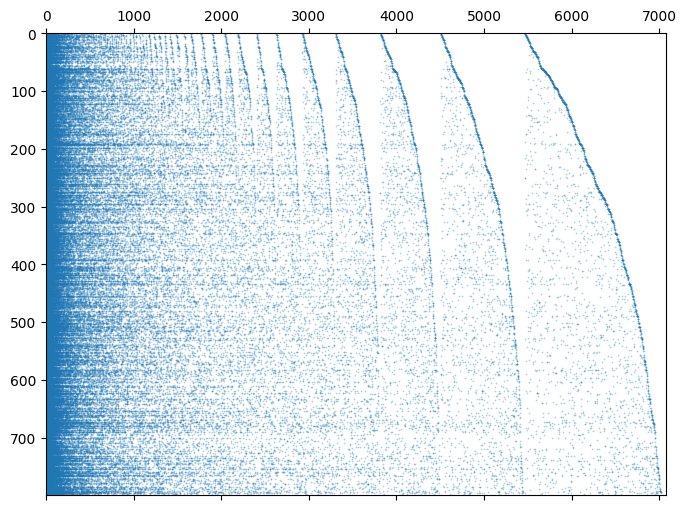

In [39]:
fig = plt.figure()
plt.spy(A, markersize=0.10, aspect = 'auto')
fig.set_size_inches(8,6)
fig.savefig('doc_term_matrix.png', dpi=800)

Выделяются несколько наблюдений:
1. Очевидно, что матрица терминов документа является разреженной, т.е. имеет высокую долю нулей! 
2. Плотность матрицы увеличивается по направлению к левому краю. Это имеет смысл, потому что токены упорядочены по частоте использования, причем частота увеличивается в направлении "влево".
3. Существует вызывающий недоумение узор изогнутых вертикальных "рябей плотности". Если у кого-нибудь есть объяснение, пожалуйста, дайте мне знать! 

Далее мы увидим, как использовать разреженность матрицы для экономии места в памяти, а также вычислительного времени и ресурсов.

## 5. Разреженное матричное представление

Несмотря на то, что мы сократили более 19 000 уникальных слов в нашем корпусе отзывов до словарного запаса в 7080 слов, это все равно много! Но отзывы, как правило, короткие, в несколько сотен слов. Таким образом, большинство токенов не появляются в типичном обзоре.  Это означает, что большинство записей в матрице терминов документа будут содержать нули, и поэтому обычные матричные операции будут тратить много вычислительных ресурсов на умножение и добавление нулей. 

Мы хотим максимально использовать пространство и время, сохраняя и выполняя матричные операции над нашей матрицей терминов-документов в виде **разреженной матрицы**. `scipy` предоставляет инструменты для эффективного представления разреженных матриц и операций с ними.

Грубо говоря, матрица с высокой долей нулей называется `разреженной` (противоположность разреженности - "плотная").  Для разреженных матриц вы можете сэкономить много памяти, сохранив только ненулевые значения.

Более конкретно, класс матриц называется **разреженным**, если количество ненулевых элементов пропорционально количеству строк (или столбцов) вместо того, чтобы быть пропорциональным произведению строк на столбцы. Примером может служить класс диагональных матриц.
<img src="../images/sparse.png" alt="floating point" style="width: 30%"/>

### Визуализация структуры разрежнной матрицы
<img src="../images/graph_g.png" alt="floating point" style="width: 50%"/>
ref. https://scipy-lectures.org/advanced/scipy_sparse/introduction.html

### Форматы хранения разреженных матриц

<img src="../images/sparse_format.png" alt="floating point" style="width: 90%"/>
ref. https://scipy-lectures.org/advanced/scipy_sparse/storage_schemes.html

Существуют наиболее распространенные разреженные форматы хранения:
- по координатам (в scipy есть COO)
- сжатая разреженная строка (CSR)
- сжатый разреженный столбец (CSC)

### Определение формата сжатой разреженной строки (CSR)

Давайте начнем с предварительного описания формата [**CSR**](https://en.wikipedia.org/wiki/Sparse_matrix)

Учитывая полную матрицу **`A`**, которая имеет **`m`** строк, **`n`** столбцов и **`N`** ненулевых значений, представление CSR (сжатая разреженная строка) использует три массива следующим образом:

1. **`Val[0:N]`** содержит **значения** из **`N` ненулевых элементов**.

2. **`Col[0:N]`** содержит **индексы столбцов** из **`N` ненулевых элементов**. 
    
3. Для каждой строки **`i`** из **`A`**, **`RowPointer[i]`** содержит индекс в **Val** первого **ненулевого значения** в строке **`i`**. Если в **i-й** строке нет ненулевых значений, то **`RowPointer[i] = None`**. И, по соглашению, дополнительное значение **`RowPointer[m] = N`** прикрепляется в конце. 

Вопрос: Сколько значений с плавающей точкой и целых чисел требуется для хранения матрицы **`A`** в формате CSR?

Здесь можно посмотреть [несколько примеров](http://www.mathcs.emory.edu/~cheung/Courses/561/Syllabus/3-C/sparse.html) на сайте университера Эмори. 

## 6. Преобразуем матрицу терминов-документов в формат CSR
, т.е. учитывая объект `TextLoader`, содержащий отзывы, определите три массива (values, column_indices, row_pointer).

### Scipy Реализация разреженных матриц

Из документации [Scipy Sparse Matrix](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html)

- Для эффективного построения матрицы используйте либо doc_matrix, либо lil_matrix. Класс lil_matrix поддерживает базовую нарезку и необычное индексирование с синтаксисом, аналогичным массивам NumPy. Как показано ниже, формат COO также может быть использован для эффективного построения матриц
- Чтобы выполнить такие манипуляции, как умножение или инверсия, сначала преобразуйте матрицу в формат CSC или CSR.
- Все преобразования между форматами CSR, CSC и COO являются эффективными операциями линейными по числу операндов.

Чтобы по-настоящему понять формат CSR, нам нужно уметь делать две вещи:
1. Переводить обычную матрицу A в формат CSR
2. Восстанавливать регулярную матрицу из ее разреженного представления CSR

### 6.1. Перевод обычной матрицы A в формат CSR
Это делается путем реализации определения формата `CSR`, приведенного выше.

In [40]:
# строим матрицу терминов документа в формате CSR
# т.е. определяем (values, column_indices, row_pointer)

def get_doc_term_matrix(token_counter, n_docs, n_terms):
    
    # ввод:
    #    Объект, TokenCounter
    #    n_docs, количество отзывов в обучающей выборке
    #    n_terms, количество токенов в словаре
    
    # вывод: 
    #    формат CSR разреженное представление матрицы терминов документа в виде
    #    объект scipy.sparse.csr.csr_matrix
    
    # Инициализация массивов
    values = []
    column_indices = []
    row_pointer = []
    row_pointer.append(0)

    for doc_index in range(n_docs):
        column_indices.extend(token_counter(doc_index).keys())
        values.extend(token_counter(doc_index).values())
        # Прикрепите N (количество ненулевых элементов в матрице) к концу массива row_pointer 
        row_pointer.append(len(values))
        
    return scipy.sparse.csr_matrix((values, column_indices, row_pointer),
                                   shape=(len(row_pointer) - 1, n_terms),
                                   dtype=int)

Получим матрицу терминов документов в формате CSR для обучающих данных 

In [41]:
%%time
train_doc_term = get_doc_term_matrix(TokenCounter, n_docs, n_terms)

CPU times: user 8.4 s, sys: 155 ms, total: 8.55 s
Wall time: 9.82 s


In [42]:
type(train_doc_term)

scipy.sparse._csr.csr_matrix

In [43]:
train_doc_term.shape

(800, 7080)

#### Задание 1.
Получить матрицу терминов документов для валидационного набора данных в CSR формате.

In [44]:
n_terms = len(movie_reviews.vocab[0])
n_docs = len(df[df.is_valid == True].text)

In [45]:
%%time
valid_doc_term = get_doc_term_matrix(TokenCounter, n_docs, n_terms)

CPU times: user 2.7 s, sys: 25.3 ms, total: 2.73 s
Wall time: 3.18 s


In [46]:
type(valid_doc_term)

scipy.sparse._csr.csr_matrix

In [47]:
valid_doc_term.shape

(200, 7080)

### 6.2 Реконструировать регулярную матрицу из ее разреженного представления CSR
Учитывая разреженное матричное представление формата `CSR` $(\text{values},\text{column_indices}, \text{row_pointer})$ a $\text{m}\times \text{n}$ matrix $\text{A}$, как мы можем восстановить $\text{A}$?

Сначала создайте матрицу $\text{m}\times \text{n}$ со всеми нулями.
Мы восстановим $\text{A}$, перезаписав записи в матрице нулей строка за строкой ненулевыми записями в $\text{A}$ следующим образом:

In [48]:
def CSR_to_full(values, column_indices, row_ptr, m,n):
    A = np.zeros(m,n)
    for row in range(n):
        if row_ptr is not null:
            A[row,column_indices[row_ptr[row]:row_ptr[row+1]]] = values[row_ptr[row]:row_ptr[row+1]]
    return A

#### Метод `.todense()` преобразует разреженную матрицу обратно в обычную (плотную) матрицу.

In [49]:
train_doc_term

<800x7080 sparse matrix of type '<class 'numpy.int64'>'
	with 114102 stored elements in Compressed Sparse Row format>

In [50]:
train_doc_term.todense()[:10,:10]

matrix([[ 7,  0,  1,  0,  0,  3,  0,  0, 14,  2],
        [19,  0,  1,  0,  0,  0,  0,  2, 32, 27],
        [ 3,  0,  1,  0,  0,  0,  0,  2, 16,  5],
        [12,  0,  1,  0,  0,  0,  0,  0, 10, 16],
        [ 8,  0,  1,  0,  0,  0,  0,  0, 21, 13],
        [ 4,  0,  1,  0,  0,  0,  0,  1, 12,  6],
        [ 4,  0,  1,  0,  0,  0,  0,  0, 15, 19],
        [39,  0,  1,  0,  0,  0,  0, 12, 42, 30],
        [15,  0,  1,  0,  0,  0,  0,  0, 26, 15],
        [18,  0,  1,  0,  0,  0,  0,  1, 22, 10]])

## 7. Упражнения

Рассмотрим `df[df.is_valid == True].text`как валидационный набор, выберем второй отзыв из него.

In [51]:
review = df[df.is_valid == True].text[df[df.is_valid == True].index[1]]
review

"I saw this movie once as a kid on the late-late show and fell in love with it.<br /><br />It took 30+ years, but I recently did find it on DVD - it wasn't cheap, either - in a catalog that specialized in war movies. We watched it last night for the first time. The audio was good, however it was grainy and had the trailers between reels. Even so, it was better than I remembered it. I was also impressed at how true it was to the play.<br /><br />The catalog is around here someplace. If you're sincere in finding it, fire me a missive and I'll see if I can get you the info. cartwrightbride@yahoo.com"

### Задание 2
Сколько раз слово "it" встречается в этом отзыве? Подтвердите, что в матрице терминов - документов сохранены правильные значения для строки, соответствующей этому отзыву, и столбца, соответствующего слову "it".

In [52]:
import re

review = list(map(lambda x : re.compile('[^a-zA-Z]').sub('', x), review.casefold().replace('<br />', ' ').split()))

In [53]:
review

['i',
 'saw',
 'this',
 'movie',
 'once',
 'as',
 'a',
 'kid',
 'on',
 'the',
 'latelate',
 'show',
 'and',
 'fell',
 'in',
 'love',
 'with',
 'it',
 'it',
 'took',
 '',
 'years',
 'but',
 'i',
 'recently',
 'did',
 'find',
 'it',
 'on',
 'dvd',
 '',
 'it',
 'wasnt',
 'cheap',
 'either',
 '',
 'in',
 'a',
 'catalog',
 'that',
 'specialized',
 'in',
 'war',
 'movies',
 'we',
 'watched',
 'it',
 'last',
 'night',
 'for',
 'the',
 'first',
 'time',
 'the',
 'audio',
 'was',
 'good',
 'however',
 'it',
 'was',
 'grainy',
 'and',
 'had',
 'the',
 'trailers',
 'between',
 'reels',
 'even',
 'so',
 'it',
 'was',
 'better',
 'than',
 'i',
 'remembered',
 'it',
 'i',
 'was',
 'also',
 'impressed',
 'at',
 'how',
 'true',
 'it',
 'was',
 'to',
 'the',
 'play',
 'the',
 'catalog',
 'is',
 'around',
 'here',
 'someplace',
 'if',
 'youre',
 'sincere',
 'in',
 'finding',
 'it',
 'fire',
 'me',
 'a',
 'missive',
 'and',
 'ill',
 'see',
 'if',
 'i',
 'can',
 'get',
 'you',
 'the',
 'info',
 'cartwrigh

In [54]:
count = review.count("it")

print(count)

10


In [55]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.text)
review_idx = df[df.is_valid == True].index[1]
it_idx = vectorizer.vocabulary_["it"]
count = X[review_idx, it_idx]

print(count)

10


### Задание 3

Подтвердите, что в отзыве содержится 144 токена, 81 из которых являются уникальными.

In [56]:
movie_reviews.tokenizer(df[df.is_valid == True].text[df[df.is_valid == True].index[1]])

(#145) ['xxbos','i','saw','this','movie','once','as','a','kid','on'...]

In [57]:
len(set(movie_reviews.tokenizer(df[df.is_valid == True].text[df[df.is_valid == True].index[1]])))

88

#### Задание 4.
 Как преобразовать список номеров токенов в токинизированный текст? Создайте функцию и проверьте ее работу на одном из отзывов.

In [58]:
word_list = [a for a in movie_reviews.tokenizer(df[df.is_valid == True].text[df[df.is_valid == True].index[1]])]
print(word_list)

['xxbos', 'i', 'saw', 'this', 'movie', 'once', 'as', 'a', 'kid', 'on', 'the', 'late', '-', 'late', 'show', 'and', 'fell', 'in', 'love', 'with', 'it', '.', '\n\n', 'xxmaj', 'it', 'took', '30', '+', 'years', ',', 'but', 'i', 'recently', 'did', 'find', 'it', 'on', 'xxup', 'dvd', '-', 'it', 'was', "n't", 'cheap', ',', 'either', '-', 'in', 'a', 'catalog', 'that', 'specialized', 'in', 'war', 'movies', '.', 'xxmaj', 'we', 'watched', 'it', 'last', 'night', 'for', 'the', 'first', 'time', '.', 'xxmaj', 'the', 'audio', 'was', 'good', ',', 'however', 'it', 'was', 'grainy', 'and', 'had', 'the', 'trailers', 'between', 'reels', '.', 'xxmaj', 'even', 'so', ',', 'it', 'was', 'better', 'than', 'i', 'remembered', 'it', '.', 'i', 'was', 'also', 'impressed', 'at', 'how', 'true', 'it', 'was', 'to', 'the', 'play', '.', '\n\n', 'xxmaj', 'the', 'catalog', 'is', 'around', 'here', 'someplace', '.', 'xxmaj', 'if', 'you', "'re", 'sincere', 'in', 'finding', 'it', ',', 'fire', 'me', 'a', 'missive', 'and', 'xxmaj', '

In [59]:
print(movie_reviews.numericalize(word_list))

TensorText([   2,   19,  244,   21,   29,  313,   27,   13,  573,   35,    9,
             478,   24,  478,  148,   12, 1206,   18,  145,   30,   17,   11,
              26,    8,   17,  598,  939, 1233,  176,   10,   31,   19,  827,
              89,  184,   17,   35,    7,  329,   24,   17,   25,   37,  569,
              10,  342,   24,   18,   13, 5267,   20,    0,   18,  356,  126,
              11,    8,   91,  316,   17,  259,  397,   28,    9,  106,   79,
              11,    8,    9, 3209,   25,   68,   10,  237,   17,   25, 4551,
              12,   85,    9, 2203,  181,    0,   11,    8,   78,   52,   10,
              17,   25,  139,   98,   19, 1795,   17,   11,   19,   25,   99,
            1370,   47,  108,  242,   17,   25,   15,    9,  384,   11,   26,
               8,    9, 5267,   16,  190,  142,    0,   11,    8,   59,   33,
             195, 6371,   18, 1593,   17,   10,  930,   90,   13,    0,   12,
               8,   19,  227,   88,   59,   19,   83,  100,   33

In [60]:
text_from_tokens = [movie_reviews.vocab[0][i] for i in movie_reviews.numericalize(word_list)]
print(' '.join(text_from_tokens))

xxbos i saw this movie once as a kid on the late - late show and fell in love with it . 

 xxmaj it took 30 + years , but i recently did find it on xxup dvd - it was n't cheap , either - in a catalog that xxunk in war movies . xxmaj we watched it last night for the first time . xxmaj the audio was good , however it was grainy and had the trailers between xxunk . xxmaj even so , it was better than i remembered it . i was also impressed at how true it was to the play . 

 xxmaj the catalog is around here xxunk . xxmaj if you 're sincere in finding it , fire me a xxunk and xxmaj i 'll see if i can get you the xxunk . xxunk


## 8. Что такое классификатор [Naive Bayes](https://towardsdatascience.com/the-naive-bayes-classifier-e92ea9f47523)? 

Модель `мешка слов` рассматривает отзыв на фильм как эквивалент списка подсчетов всех токенов, которые он содержит. Когда вы делаете это, вы отбрасываете богатую информацию, получаемую в результате последовательного расположения токенов в предложениях и абзацах. 

Тем не менее, даже если вам не разрешают читать отзыв, а дают только его представление в виде "количества токенов", вы обычно все равно можете получить довольно хорошее представление о том, был ли отзыв хорошим или плохим. Как вы это делаете?  Мысленно оценивая общее `позитивное` или `негативное` настроение, которое передает набор слов, верно?  

Наивный байесовский классификатор (`Naive Bayes Classifier`) - это алгоритм, который математически кодирует этот простой процесс рассуждения. Он основан на двух важных элементах информации, которые мы можем извлечь из обучающего набора:
* Критерии оценки класса (`class priors`), то есть вероятности того, что случайно выбранный отзыв будет положительным или отрицательным
* Вероятность токена (`token likelihoods`), т.е. насколько вероятно, что данный токен появится в положительном или отрицательном отзыве 

Оказывается, это вся информация, которая нам нужна для построения модели, способной довольно точно предсказать, как будет классифицирован любой данный обзор, учитывая его текст! 

Мы развернем полное объяснение магии наивного байесовского классификатора в следующем разделе. 

Между тем, в этом разделе мы сосредоточимся на том, как вычислить необходимую информацию из обучающих данных, в частности, априорные вероятности для отзовов каждого класса, а также количество встречаемости классов (`class occurrence counts`) и отношения правдоподобия классов `class likelihood ratios`) для каждого токена в словаре.

### 8A. Критерии оценки класса

Из обучающих данных мы можем определить "приоры класса" $p$ и $q$, которые представляют собой общие вероятности того, что случайно выбранный отзыв относится к положительному или отрицательному классу, соответственно. 

$p=\frac{N^{+}}{N}$
и
$q=\frac{N^{-}}{N}$ 

Здесь $N ^ {+}$ и $N ^ {-}$ - это количество положительных и отрицательных отзывов, а $N$ - общее количество отзывов в обучающем наборе, так что 

$N = N^{+} + N^{-}$,
и 
$q = 1-p$

### 8B. Количества встречаемости класса

Пусть $C ^ {+} _ {t} $ и $C ^ {-}_{t}$ будут количеством встречаемости токена $t$ в положительных и отрицательных отзывах соответственно, а $N ^ {+} $ и $N ^ {-}$ - общее количество положительных и отрицательных отзывов в наборе данных соответственно.

### 8B.1 Анализ данных с расчетом количеств встречаемости класса

Классы и их целочисленные представления

In [61]:
dir(movie_reviews)[0:10]

['_DataLoader__idxs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__']

In [62]:
movie_reviews.c

2

In [63]:
movie_reviews.vocab[1]

['negative', 'positive']

In [64]:
positive = list(movie_reviews.vocab[1]).index('positive')
negative =  list(movie_reviews.vocab[1]).index('negative')
print(f'Целочисленное представление классов:  положительный: {positive}, отрицательный: {negative}')

Целочисленное представление классов:  положительный: 1, отрицательный: 0


Сократим переменные для матрицы терминов-документов обучающего набора и ее меток, меток проверки и словарного запаса

In [65]:
movie_reviews.train_ds[2][1].item()

0

In [66]:
x = train_doc_term
y = np.array([i[1].item() for i in movie_reviews.train_ds])
valid_y = np.array([i[1].item() for i in movie_reviews.valid_ds])

In [67]:
x.shape

(800, 7080)

Массивы подсчета `C1` и `C0` перечисляют общее количество встречаемости токенов в положительных и отрицательных отзывах соответственно.

In [68]:
C1 = np.squeeze(np.asarray(x[y==1].sum(0)))
C0 = np.squeeze(np.asarray(x[y==0].sum(0)))

Для каждого словарного знака мы суммируем количество положительных отзывов о нем и количество отрицательных отзывов о нем. Вот количество встречаемости первых 10 лексем в словаре.

In [69]:
print(C1[:10])
print(C0[:10])

[5706    0  383    0    0   64    0  627 9675 5249]
[ 6286     0   417     0     0    93     3   852 10288  6143]


### 8B.2 Упражнения

Мы можем использовать `C0` и `C1` для дальнейшего изучения данных!

### Задание 5. 
Сравните, как часто слово "love" встречается в положительных отзывах по сравнению с отрицательными.  Проделайте то же самое со словом "hate".

In [70]:
ind = list(movie_reviews.vocab[0]).index('love')
pos_counts = C1[ind] 
neg_counts = C0[ind] 
print(f'Слово "love" встречается {pos_counts} и {neg_counts} раз в положительных и отрицательных отзывах, соответственно')

Слово "love" встречается 132 и 75 раз в положительных и отрицательных отзывах, соответственно


In [71]:
ind = list(movie_reviews.vocab[0]).index('hate')
pos_counts = C1[ind] 
neg_counts = C0[ind] 
print(f'Слово "hate" встречается {pos_counts} и {neg_counts} раз в положительных и отрицательных отзывах, соответственно')

Слово "hate" встречается 5 и 13 раз в положительных и отрицательных отзывах, соответственно


Давайте посмотрим на пример положительного отзыва, содержащего слово "hated"

In [72]:
ind = list(movie_reviews.vocab[0]).index('hate')
a = np.argwhere((x[:,ind] > 0))[:,0]
print(a)
b = np.argwhere(y==1)[:,0]
print(b)
c = list(set(a).intersection(set(b)))[0]
review = df[df.is_valid == False].text[int(c)]
review

[118 198 222 260 296 321 323 330 451 489 498 512 559 567 609 751 774]
[  1   3  10  11  12  13  14  18  19  20  25  26  29  30  32  33  35  36
  39  40  41  42  43  46  47  50  52  53  55  57  58  61  69  72  73  74
  75  76  77  78  79  80  84  85  87  89  90  91  93  96  99 100 101 102
 103 105 108 110 112 114 116 117 120 124 127 132 133 137 138 143 145 147
 148 149 152 153 160 162 164 165 170 172 174 175 177 178 180 182 184 185
 187 188 191 192 194 196 197 198 201 202 203 206 207 208 211 216 217 223
 225 227 228 229 232 233 236 242 244 245 248 250 253 255 256 258 259 261
 262 264 265 267 268 269 271 272 275 276 277 280 282 283 286 287 289 291
 292 296 297 298 300 305 306 308 309 310 313 316 320 323 325 326 328 333
 335 337 339 341 342 344 345 347 350 355 356 357 360 361 366 368 377 379
 381 383 384 390 391 393 394 396 399 400 402 404 406 407 412 413 416 417
 420 422 423 425 426 430 437 438 440 441 442 443 444 446 449 450 452 453
 454 458 459 460 463 465 468 470 474 476 477 478 479 4

'I reached the end of this and I was almost shouting "No, no, no, NO! It cannot end here! There are too many unanswered questions! The engagement of the dishwashers? Mona\'s disappearance? Helmer\'s comeuppance? The "zombie"? Was Little Brother saved by his father? And what about the head???????" ARGH!! Then I read that at least two of the cast members had passed on and I have to say, I know it probably wouldn\'t be true to Lars von Trier\'s vision, but I would gladly look past replacement actors just to see the ending he had planned! Granted, it would be hard to find someone to play Helmer as the character deserves. Helmer, the doctor you love to hate! I think I have yet to see a more self-absorbed, oblivious, self-righteous character on screen! But, I could overlook a change in actors....I just have to know how it ends!'

Пример отрицательного отзыва со словом "loved"

In [73]:
ind = list(movie_reviews.vocab[0]).index('love')
a = np.argwhere((x[:,ind] > 0))[:,0]
print(a)
b = np.argwhere(y==1)[:,0]
print(b)
c = list(set(a).intersection(set(b)))[0]
review = df[df.is_valid == False].text[int(c)]
review

[ 18  21  24  25  30  33  50  57  62  70  75  82  89  95 101 109 110 116
 120 123 131 133 151 161 162 168 174 182 187 191 192 194 198 217 221 227
 246 247 253 255 284 291 295 296 304 308 309 321 326 338 340 345 347 356
 368 379 380 391 392 394 407 409 420 423 425 439 441 450 453 456 459 460
 463 470 473 484 488 489 490 491 492 498 502 512 518 520 523 524 528 531
 532 548 552 553 554 568 575 587 588 598 609 616 627 628 642 652 657 664
 669 672 683 695 696 697 709 711 724 731 735 736 739 741 742 748 749 751
 754 756 759 767 772 776 784 789 792 794]
[  1   3  10  11  12  13  14  18  19  20  25  26  29  30  32  33  35  36
  39  40  41  42  43  46  47  50  52  53  55  57  58  61  69  72  73  74
  75  76  77  78  79  80  84  85  87  89  90  91  93  96  99 100 101 102
 103 105 108 110 112 114 116 117 120 124 127 132 133 137 138 143 145 147
 148 149 152 153 160 162 164 165 170 172 174 175 177 178 180 182 184 185
 187 188 191 192 194 196 197 198 201 202 203 206 207 208 211 216 217 223
 225 227 

'My kids recently started watching the reruns of this show - both the early episodes on the N, and the later ones on ABC Family - and they love it. (I wasn\'t aware the show had even lasted past the first or second season) I\'m curious as to what prompted all of the cast changes - I\'ve seen them described as "highly publicized," and yet a half hours searching efforts on the web have revealed nothing but endless comments on how the early episodes were so much better than the later episodes. (Personally, I don\'t see a whole lot of difference - the scripts and themes remain largely the same throughout - but they do lose some great people along the way) My daughter has put the DVDs on her wish list, so perhaps the land of special features and commentary will shed some light on all of this. I also wish they\'d done some self-referential humor about the changes - like on "Boy Meets World" where they drop the little sister for an entire season or so, and when a different actor later shows u

### 8C. Отношения вероятности классов

Затем, учитывая знание того, что отзыв классифицируется как, условная вероятность того, что токен $t$ появится в положительныом отзыве, равна
$ L (t|+) = \frac {C ^ {+}_{t}}{N ^ +}$, и точно так же условная вероятность появления токена в отрицательном отзыве равна 
$ L(t|-) = \frac{C^{-}_{t}}{N^-}$

### 8D. Логарифм отношения вероятностей классов `log-count ratio`

Из коэффициентов правдоподобия класса мы можем определить **логарифм отношения вероятностей классов** $R_{t}$ для каждого токена $t$ как
$ R_{t} = \text{log} \frac {L(t|+)} {L(t|-)}$
Логарифм отношения вероятностей классов ранжирует токены по их относительной близости к положительным и отрицательным отзывам
Очевидно, что
* $R_{t} \gt 0$ означает, что положительные отзывы с большей вероятностью будут содержать этот токен 
* $R_{t} \lt 0$ означает, что отрицательные отзывы с большей вероятностью будут содержать этот токен 
* $R_{t} = 0$ указывает, что токен $t$ с равной вероятностью появится в положительных и отрицательных отзывах


## 9. Построение наивного байесовского классификатора для обзоров фильмов IMDb

Из массивов чисел появлений токенов можно вычислить вероятности классов и логарифма их отношений для всех токенов в словаре.

### 9A. Вычисление вероятностей с учетом новых слов классов

Вычислим слегка измененные условные вероятности, добавляя 1 к числителю и знаменателю, чтобы обеспечить численную стабильность при появлении новых слов

In [74]:
L1 = (C1+1) / ((y==1).sum() + 1)
L0 = (C0+1) / ((y==0).sum() + 1)

### 9B. Вычислим новые логарифмы отношений вероятностей

Логарифмы отношений вероятностей имееют следующий вид:

In [75]:
R = np.log(L1/L0)
print(R)

[-0.01195164  0.08483888  0.         ...  0.08483888  0.08483888
  0.08483888]


**Упражнение с данными**: найдите словарные слова, которые с наибольшей вероятностью будут ассоциироваться с положительными и отрицательными отзывами.

Получите индексы токенов с самым высоким и самым низким логарифмом отношения вероятностей

In [76]:
n_tokens = 10
highest_R = np.argpartition(R, -n_tokens)[-n_tokens:]
lowest_R = np.argpartition(R, n_tokens)[:n_tokens]

In [77]:
print(f'Наивысшие {n_tokens} логарифмы отношений: {R[list(highest_R)]}\n')
print(f'Наинизшие {n_tokens} логарифмы отношений: {R[list(lowest_R)]}')

Наивысшие 10 логарифмы отношений: [2.56974553 2.64978824 2.64978824 2.72389621 2.64978824 2.72389621
 2.97521064 2.8574276  3.02927786 2.79288908]

Наинизшие 10 логарифмы отношений: [-3.09321495 -3.13403694 -2.8596001  -2.55421845 -2.63645655 -2.55421845
 -2.74837446 -2.68774984 -2.62321132 -2.80553288]


Наиболе позитивные слова:

In [78]:
highest_R

array([2150, 2036, 1967,  937, 1766, 1758, 1484, 1646, 1414, 1194])

In [79]:
[movie_reviews.vocab[0][k] for k in highest_R]

['paxton',
 'gilliam',
 'jabba',
 'jimmy',
 'davies',
 'felix',
 'fanfan',
 'astaire',
 'biko',
 'noir']

Есть только два отзыва на фильм, в которых упоминается "biko".

In [80]:
token = ['biko']
ind = movie_reviews.numericalize(token).item()
(train_doc_term[:,ind]!=0).sum()

2

В каком отзыве фильма больше всего встречается 'biko'?

In [81]:
index = np.argmax(train_doc_term[:,ind])
n_times = train_doc_term[index,ind]
print(f'Отзыв # {index} содержит {n_times} упоминаний "{token[0]}"\n')
print(df.text[index])

Отзыв # 515 содержит 14 упоминаний "biko"

"The True Story Of The Friendship That Shook South Africa And Awakened The World." <br /><br />Richard Attenborough, who directed "A Bridge Too Far" and "Gandhi", wanted to bring the story of Steve Biko to life, and the journey and trouble that journalist Donald Woods went through in order to get his story told. The films uses Wood's two books for it's information and basis - "Biko" and "Asking for Trouble".<br /><br />The film takes place in the late 1970's, in South Africa. South Africa is in the grip of the terrible apartheid, which keeps the blacks separated from the whites and classifies the whites as the superior race. The blacks are forced to live in shantytowns on the outskirts of the cities and towns, and they come under frequent harassment by the police and the army. We are shown a dawn raid on a shantytown, as bulldozers and armed police force their way through the camp beating and even killing the inhabitants. Then we are introduce

Наиболее отрицательные слова:

In [82]:
lowest_R

array([1139,  988,  559, 1895,  288, 1896, 1140, 1635, 1344, 1452])

In [83]:
[movie_reviews.vocab[0][k] for k in lowest_R]

['vargas',
 'porn',
 'crap',
 'fuqua',
 'worst',
 'soderbergh',
 'dog',
 'crater',
 'disappointment',
 'naschy']

Есть только один отзыв на фильм, в которой упоминается 'soderbergh'.

In [84]:
token = ['soderbergh']
ind = movie_reviews.numericalize(token).item()
(train_doc_term[:,ind]!=0).sum()

1

In [85]:
index = np.argmax(train_doc_term[:,ind])
n_times = train_doc_term[index,ind]
print(f'Отзыв # {index} содержит {n_times} упоминаний "{token[0]}"\n')
print(df.text[index])

Отзыв # 434 содержит 13 упоминаний "soderbergh"

Now that Che(2008) has finished its relatively short Australian cinema run (extremely limited release:1 screen in Sydney, after 6wks), I can guiltlessly join both hosts of "At The Movies" in taking Steven Soderbergh to task.<br /><br />It's usually satisfying to watch a film director change his style/subject, but Soderbergh's most recent stinker, The Girlfriend Experience(2009), was also missing a story, so narrative (and editing?) seem to suddenly be Soderbergh's main challenge. Strange, after 20-odd years in the business. He was probably never much good at narrative, just hid it well inside "edgy" projects.<br /><br />None of this excuses him this present, almost diabolical failure. As David Stratton warns, "two parts of Che don't (even) make a whole". <br /><br />Epic biopic in name only, Che(2008) barely qualifies as a feature film! It certainly has no legs, inasmuch as except for its uncharacteristic ultimate resolution forced upon 

### 9C. Вычислим априорные вероятности для каждого класса


In [86]:
p = (y==1).mean()
q = (y==0).mean()
print(f'Априорные вероятности для положительного и отрицательного классов следующие: {p} и {q}')

Априорные вероятности для положительного и отрицательного классов следующие: 0.47875 и 0.52125


Логарифм отношений вероятности
равен $b = \text{log} \frac{p} {q}$ 
является мерой "предвзятости" или "дисбаланса` в наборе данных. 

* $b = 0$ указывает на идеально сбалансированный набор данных
* $b \gt 0$ указывает на склонность к положительным отзывам 
* $b \lt 0$ указывает на предвзятость в отношении негативных отзывов

In [87]:
b = np.log((y==1).mean() / (y==0).mean())
print(f'Логарифм отношения вероятностей L = {b}')

Логарифм отношения вероятностей L = -0.08505123261815539


Мы видим, что набор тренировок слегка несбалансирован в сторону негативных отзывов.

### 9D. Собирая все это воедино: классификатор отзывов фильмов наивного Байеса
В этом разделе мы начнем с обсуждения теоремы Байеса, затем будем использовать ее для получения наивного байесовского классификатора. Далее мы применим классификатор наивного Байеса к нашей задаче с отзывами фильмов. Наконец, мы рассмотрим рецепт построения наивного байесовского классификатора.

### 9D.1 Что такое теорема Байеса и что она говорит об отзывах фильмов IMDb?
---
Рассмотрим два события, $A$ и $B$  
Тогда вероятность того, что $A$ и $B$ произойдут вместе, может быть записана двумя способами:
$p(A,B) = p(A|B)\cdot p(B)$ <br>
$p(A,B) = p(B|A)\cdot p(A)$

где $p(A|B)$ и $p(B|A)$ - условные вероятности:
$p(A |B)$ - вероятность возникновения $A$, учитывая, что $B$ произошло,
$p (A)$ - вероятность того, что $A$ произойдет,
$p(B)$ - вероятность того, что $B$ произойдет

$ \textbf {Теорема Байеса} $ - это просто утверждение о том, что правые части двух приведенных выше уравнений равны:

$p(A|B) \cdot p(B) = p(B|A) \cdot p(A)$

Применение $\textbf {Теорема Байеса}$ к нашей задаче с обзором фильмов на IMDb:

Мы идентифицируем $A$ и $B$ как <br> 
$A \equiv \text{класс}$, т.е. положительный или отрицательный, и <br>
$B \equiv \text{токены}$, т.е. "пакет" токенов, используемых в отзывах.

Тогда $\textbf {теорема Байеса}$ говорит

$p(\text{класс}|\text{токены})\cdot p(\text{токены}) = p(\text{токены}|\text{класс}) \cdot p(\text{класс})$

Левая часть приведенного выше выражения называется $\textbf {вероятность апостериорного класса}$, вероятность того, что отзыв будет положительным (или отрицательным), учитывая содержащиеся в нем токены. Это именно то, что мы хотим предсказать!

### 9D.2 Наивный Байесовский классификатор

Учитывая список токенов в обзоре, мы стремимся предсказать, будет ли отзыв оценен как положительный или отрицательный.
Мы можем сделать прогноз, если знаем вероятности апостериорного класса.
$p(\text{class}|\text{tokens})$, где $\text{class}$ является либо положительным, либо отрицательным, а $\text{tokens}$ - это список токенов, которые отображаются в обзоре.
[Теорема Байеса](https://en.wikipedia.org/wiki/Bayes%27_theorem) говорит нам, что апостериорные вероятности, правдоподобия и априорные значения связаны таким образом:
$p(\text{class}|\text{tokens}) \propto p(\text{tokens}|\text{class})\cdot p(\text{class})$
Теперь токены не являются независимыми друг от друга. Например, "перейти" часто появляется с кому, поэтому, если перейти появляется в обзоре, более вероятно, что обзор также содержит кому. Тем не менее, предположение, что токены независимы, позволяет нам упростить ситуацию, поэтому мы опрометчиво делаем это, надеясь, что это не слишком неправильно!
$p(\text{tokens}|\text{class}) = \prod_{i=1}^{n} p(t_{i}|\text{class})$
где $t_{i}$ - токен $i\text{th}$ в словаре, а $n$ - количество токенов в словаре. Итак, теорема Байеса такова
: $p(\text{class}|\text{tokens}) \propto p(\text{class}) \prod_{i=1} ^{n} p(t_{i}|\text{class})$

Принимая соотношение $\textbf{вероятности апостериорного класса}$ для положительных и отрицательных классов, мы имеем $\frac{p(+|\text{tokens})}{p( - |\text{tokens})} = \frac{p(+)}{p(-)} \cdot \prod_{i=1}^{n} \frac {p(t_{i}|+)} {p(t_{i}|- )} = \frac{p}{q} \cdot \prod_{i=1}^{n} \frac {L(t_{i}|+)} {L(t_{i}| - )}$
поскольку вероятности пропорциональны вероятностям.
Взятие логарифма обеих сторон преобразует это в линейную задачу:
$\text{log} \frac{p(+|\text{tokens})}{p( - |\text{tokens})} = \text{log}\frac{p}{q} + \sum_{i=1}^{n} \text{log} \frac {L(t_{i}|+)} {L(t_{i}| - )} = b + \sum_{i=1}^{n} R_{t_{i}}$

Первый член в правой части - это "смещение", а второй член - это точечное произведение *бинаризованного* вектора вложения и логарифма вероятностей.

Если левая часть больше или равна нулю, мы прогнозируем, что отзыв положительный, в противном случае мы прогнозируем, что отзыв отрицательный.

Мы можем переписать последнее уравнение в матричной форме, чтобы сгенерировать $m\times 1$ вектор логического столбца $\textbf{preds}$ прогнозов обзора:
$\textbf{preds} = \textbf{W} \cdot \textbf{R} + \textbf{b}$
где:
* $\textbf{preds} \equiv \text{log} \frac{p(+|\text{tokens})}{p( - |\text{tokens})}$
* $\textbf{W}$ - это бинаризованная матрица терминов документа $m\times n$, строки которой являются бинаризованными векторами вложения для обзоров фильмов
* $\textbf{R}$ - это $n\times 1$ вектор коэффициентов логарифмического подсчета для токенов, и
* $ \textbf{b}$ - это вектор $n\times 1$, элементы которого являются смещением $b$

Наивная байесовская модель состоит из вектора логарифмических подсчетов $\textbf{R}$ и смещения $\textbf{b}$

### 9Е. Реализация наивного байесовского классификатора отзывов на фильмы
Используйем его для прогнозирования меток для обучающих и проверочных наборов данных IMDb_sample.

In [88]:
W = train_doc_term.sign()
preds_train = (W @ R + b) > 0
train_accuracy = (preds_train == y).mean()
print(f'Точность предсказания на обучающей выборке {train_accuracy}')

Точность предсказания на обучающей выборке 0.91


### Задание 6.
Проверьте точность предсказаний бейсовского классификатора на проверочной выборке.

In [89]:
W = valid_doc_term.sign()
preds_valid = (W @ R + b) > 0
valid_accuracy = (preds_valid == valid_y).mean()
print(f'Точность предсказания на проверочной выборке {valid_accuracy}')

Точность предсказания на проверочной выборке 0.48


### 9F. Резюме: Рецепт для наивного байесовского классификатора
Вот краткое изложение нашей процедуры прогнозирования меток с помощью наивного байесовского классификатора, начиная с обучающего набора `x` и обучающих меток `y`.

- Вычислить векторы количества токенов
> C0 = np.squeeze(np.asarray(x[y==0].sum(0))) <br> 
> C1 = np.squeeze(np.asarray(x[y==1].sum(0))) <br> 

- Вычислить векторы правдоподобия класса токенов
> L0 = (C0+1) / ((y==0).sum() + 1) <br> 
> L1 = (C1+1) / ((y==1).sum() + 1) <br> 

- Вычислите вектор коэффициентов логарифмического подсчета
> R = np.log(L1/L0)

- Вычислите член смещения
> b = np.log((y==1).mean() / (y==0).mean())

- Наивная байесовская модель состоит из вектора логарифмических подсчетов $\textbf{R}$ и смещения $\textbf{b}$
- Прогнозировать метки просмотра фильмов на основе линейного преобразования вектора коэффициентов логарифмического подсчета:
> preds = (W @ R + b) > 0, <br> 
где матрица весов `W = train_doc_term.sign()` - это бинаризованная матрица `train_doc_term`, строки которой являются бинаризованными векторами вложения для отзывов фильмов, для которых вы хотите предсказать рейтинги.


Теперь, когда наш подход работает на меньшей выборке данных, мы можем попробовать использовать его на полном наборе данных.

## References

* Baselines and Bigrams: Simple, Good Sentiment and Topic Classification. Sida Wang and Christopher D. Manning [pdf](https://www.aclweb.org/anthology/P12-2018)
* [The Naive Bayes Classifier](https://towardsdatascience.com/the-naive-bayes-classifier-e92ea9f47523). Joseph Catanzarite, in Towards Data Science